In [1]:
# This should be called before numpy is imported.
import os
os.environ["OMP_NUM_THREADS"] = '1'

In [2]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import set_style
set_style("whitegrid")

In [3]:
pd.options.mode.chained_assignment = None

In [4]:
import warnings
warnings.filterwarnings(action = 'ignore')
warnings.simplefilter(action = 'ignore', category = FutureWarning)

## Preprocessing

In [5]:
games = pd.read_json('output/RPGproducts.json')

In [6]:
games

name  \
0                                 Karpov   
1                             Holy Catch   
2                    Sakura Kanji Ketchi   
3      Mechaneer Resta's Grand Adventure   
4      Adventures of Skye the Slime Maid   
...                                  ...   
10011                       Takara Cards   
10012             The Ship: Murder Party   
10013                        Bakeborough   
10014          赌神模拟器：亚洲风云God Of Gamblers   
10015             Geneforge 4: Rebellion   

                                                    tags  num_reviews  \
0      [RPG, Visual Novel, Simulation, Horror, Multip...          1.0   
1      [Adventure, RPG, Action-Adventure, Action RPG,...          NaN   
2      [Casual, RPG, Action RPG, Education, Trivia, 2...          NaN   
3      [Adventure, RPG, JRPG, 2D, Singleplayer, Anime...         19.0   
4      [Casual, RPG, Visual Novel, Anime, Colorful, T...          0.0   
...                                                  ...          ...   
10011  [Early Access, Turn-Based Tactics, Roguelite, ...         19.0   
10012  [Multiplayer, Indie, First-Person, Action, Ste...       2538.0   
10013  [Indie, Adventure, Pixel Graphics, Colorful, C...          1.0   
10014  [Sexual Content, Nudity, Mature, Gambling, Mys...        133.0   
10015  [RPG, Indie, Strategy, Isometric, Turn-Based C...         26.0   

       num_positive_reviews  \
0                       1.0   
1                       NaN   
2                       NaN   
3                      14.0   
4                       0.0   
...                     ...   
10011                  19.0   
10012                2129.0   
10013                   1.0   
10014                  40.0   
10015                  26.0   

                                                     url  release_month  \
0      https://store.steampowered.com/app/2328680/Kar...              4   
1      https://store.steampowered.com/app/2350760/Hol...              4   
2      https://store.steampowered.com/app/2364800/Sak...              4   
3      https://store.steampowered.com/app/2219800/Mec...              4   
4      https://store.steampowered.com/app/2106600/Adv...              4   
...                                                  ...            ...   
10011  https://store.steampowered.com/app/1932210/Tak...              3   
10012  https://store.steampowered.com/app/2400/The_Sh...              7   
10013  https://store.steampowered.com/app/2093050/Bak...              3   
10014  https://store.steampowered.com/app/2091550/God...              3   
10015  https://store.steampowered.com/app/201000/Gene...             11   

       release_day  release_year  
0                9          2023  
1                8          2023  
2                8          2023  
3                7          2023  
4                7          2023  
...            ...           ...  
10011           28          2023  
10012           11          2006  
10013           28          2023  
10014           28          2023  
10015            1          2006  

[10016 rows x 8 columns]

In [8]:
games[['num_reviews', 'num_positive_reviews']] = games[['num_reviews', 'num_positive_reviews']].fillna(0)

In [7]:
games['tags'] = games['tags'].apply(lambda x: [tag.replace(" ", "").replace("-", "").lower() for tag in x])
games['tags'] = games['tags'].apply(lambda x: list(set(x)))

In [9]:
games['tags'][0]

['singleplayer',
 'storyrich',
 'exploration',
 'narration',
 'rpg',
 'simulation',
 '2dplatformer',
 '2d',
 'atmospheric',
 'emotional',
 'psychologicalhorror',
 'indie',
 'multipleendings',
 'choicesmatter',
 'visualnovel',
 'horror']

In [10]:
all_tags  = []

for tags in games.tags:
    for tag in tags:
        if tag not in all_tags:
            all_tags.append(tag)

In [11]:
print(len(all_tags))

425


In [12]:
games['tags'] = games['tags'].apply(lambda x: [tag for tag in x if tag not in ['rpg', 'earlyaccess']])

In [13]:
tag_dict  = {}

for tags in games.tags:
    for tag in tags:
        if tag not in tag_dict:
            tag_dict[tag] = 1
        else:
            tag_dict[tag] += 1

tag_counts = pd.DataFrame(tag_dict.items(), columns=['tag', 'count'])
tag_counts.sort_values(by = ['count'], inplace = True, ascending = False)
tag_counts.reset_index(drop = True, inplace = True)

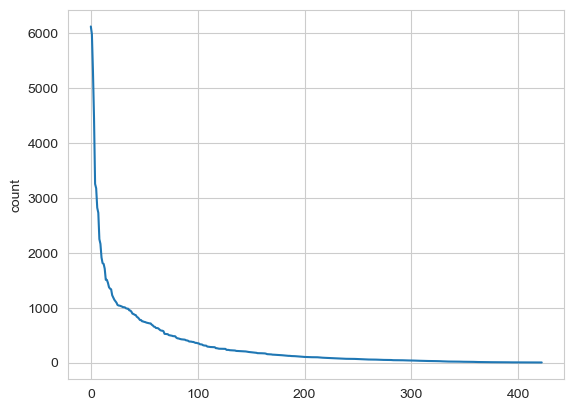

In [14]:
sns.lineplot(x = tag_counts.index, y = 'count', data = tag_counts);

In [15]:
tag_counts[0:50]

tag  count
0                    indie   6128
1                adventure   5989
2             singleplayer   5313
3                   action   4452
4                       2d   3257
5                  fantasy   3177
6                   casual   2823
7                 strategy   2730
8                storyrich   2250
9            pixelgraphics   2163
10               actionrpg   1915
11              simulation   1812
12             exploration   1798
13                   anime   1711
14             atmospheric   1508
15               openworld   1508
16                    jrpg   1454
17                      3d   1374
18       femaleprotagonist   1347
19         turnbasedcombat   1336
20         actionadventure   1227
21                    cute   1184
22               roguelike   1145
23          dungeoncrawler   1118
24             multiplayer   1092
25                   magic   1050
26                 topdown   1040
27                colorful   1037
28                   retro   1030
29                rpgmaker   1022
30                survival   1010
31             thirdperson   1009
32           choicesmatter   1004
33                   funny    988
34               roguelite    983
35            hackandslash    981
36                  combat    951
37  charactercustomization    948
38               turnbased    926
39                  puzzle    890
40                medieval    885
41       turnbasedstrategy    870
42                   scifi    866
43              freetoplay    835
44        turnbasedtactics    822
45         multipleendings    801
46                  horror    775
47                crafting    775
48             firstperson    752
49             darkfantasy    749

In [16]:
tag_counts[50:100]

tag  count
50             visualnovel    741
51             strategyrpg    737
52               difficult    728
53         greatsoundtrack    723
54                 sandbox    717
55           partybasedrpg    714
56             tacticalrpg    713
57  chooseyourownadventure    690
58           sexualcontent    677
59                    coop    655
60                  nudity    650
61                  comedy    629
62    proceduralgeneration    629
63                 violent    624
64                 shooter    607
65         actionroguelike    590
66                tactical    582
67                     pve    580
68                    crpg    571
69               oldschool    523
70    massivelymultiplayer    522
71               textbased    519
72               isometric    517
73                    dark    500
74      interactivefiction    496
75              controller    491
76                    gore    488
77                     pvp    481
78                stylized    481
79              platformer    478
80                cartoony    454
81                relaxing    442
82                building    439
83                 mystery    432
84                  arcade    427
85          familyfriendly    423
86         postapocalyptic    422
87                     fps    419
88            2dplatformer    417
89              onlinecoop    406
90                    loot    403
91               handdrawn    397
92             replayvalue    384
93              management    383
94     psychologicalhorror    381
95                   space    376
96                   drama    375
97            sidescroller    367
98                cardgame    358
99                      vr    358

In [17]:
tag_counts[100:150]

tag  count
100              zombies    351
101           permadeath    350
102               linear    334
103            realistic    332
104            soulslike    329
105              romance    316
106         basebuilding    311
107               mmorpg    310
108              cartoon    307
109             lorerich    291
110           bullethell    288
111               lgbtq+    287
112           futuristic    283
113           historical    282
114          point&click    281
115         3dplatformer    280
116               mature    279
117                memes    262
118              lifesim    261
119         immersivesim    257
120            emotional    252
121            datingsim    252
122   resourcemanagement    250
123                 2.5d    250
124       survivalhorror    250
125       topdownshooter    249
126            localcoop    249
127         conversation    231
128           minimalist    230
129         metroidvania    230
130          cardbattler    225
131            cyberpunk    224
132         deckbuilding    223
133               demons    223
134               1990's    222
135                  war    219
136               hentai    212
137               sports    211
138            boardgame    211
139              clicker    210
140  inventorymanagement    209
141              classic    207
142              dragons    206
143             tabletop    203
144    gridbasedmovement    202
145   thirdpersonshooter    202
146            darkhumor    198
147            swordplay    196
148       mysterydungeon    192
149           classbased    189

In [18]:
tag_counts[150:200]

tag  count
150                 surreal    188
151                   idler    186
152               beat'emup    183
153              shoot'emup    181
154                     rts    178
155                 stealth    177
156        localmultiplayer    171
157  openworldsurvivalcraft    171
158            towerdefense    170
159               narration    170
160        puzzleplatformer    169
161               nonlinear    168
162                  robots    167
163                  nature    166
164               detective    161
165               mythology    153
166        walkingsimulator    152
167                 physics    152
168              farmingsim    151
169                    nsfw    148
170            hiddenobject    144
171       creaturecollector    144
172            collectathon    142
173                  racing    141
174           investigation    140
175                 economy    140
176                  aliens    137
177         realtimetactics    136
178            lovecraftian    134
179               dystopian    133
180                fighting    131
181    traditionalroguelike    130
182        alternatehistory    128
183             citybuilder    125
184               education    123
185          timemanagement    122
186               comicbook    122
187     characteractiongame    119
188        twinstickshooter    118
189                military    118
190               cinematic    116
191            supernatural    116
192                   short    115
193             agriculture    114
194                   1980s    111
195                 wargame    110
196               2dfighter    108
197               teambased    106
198                moddable    102
199                  gothic    102

In [19]:
cutoff = 199
top_tags = set(tag_counts.loc[0:cutoff, 'tag'])

In [20]:
games_top_tags = games
games_top_tags['tags'] = games_top_tags['tags'].apply(lambda x: list(set(x).intersection(top_tags)) if not set(x).isdisjoint(top_tags) else [])

In [21]:
games_top_tags['num_reviews'].describe()

count    1.001600e+04
mean     1.731649e+03
std      2.450548e+04
min      0.000000e+00
25%      6.000000e+00
50%      2.900000e+01
75%      2.200000e+02
max      1.960357e+06
Name: num_reviews, dtype: float64

In [22]:
top_games_top_tags = games_top_tags[games_top_tags['num_reviews'] > 28]

In [23]:
num_tags = top_games_top_tags['tags'].apply(lambda x: len(x))
num_tags.describe()

count    5059.000000
mean       13.862423
std         5.053065
min         1.000000
25%        10.000000
50%        16.000000
75%        18.000000
max        19.000000
Name: tags, dtype: float64

In [24]:
top_games_top_tags[num_tags == 3].head(50).tags

367                           [action, adventure, indie]
389     [gridbasedmovement, dungeoncrawler, firstperson]
513                             [strategy, rts, fantasy]
555                         [roguelike, strategy, indie]
624                        [roguelike, turnbased, indie]
629                        [strategy, indie, simulation]
651                             [strategy, space, indie]
729                             [action, indie, zombies]
730                     [strategy, rts, postapocalyptic]
821                              [action, indie, casual]
836                          [strategy, indie, cardgame]
851                          [strategy, indie, rpgmaker]
864                           [action, adventure, indie]
870                     [singleplayer, turnbased, indie]
933                           [action, adventure, indie]
989                    [strategy, adventure, simulation]
998                         [action, multiplayer, indie]
1000              [strategy, tu

In [25]:
top_games_top_tags = top_games_top_tags[num_tags > 3]

In [26]:
tags_array = list(top_games_top_tags['tags']) 
vectorizer = CountVectorizer(analyzer = lambda x : x)
X = vectorizer.fit_transform(tags_array).toarray()

## PCA

In [27]:
pca = PCA()
X_pca = pca.fit_transform(X)

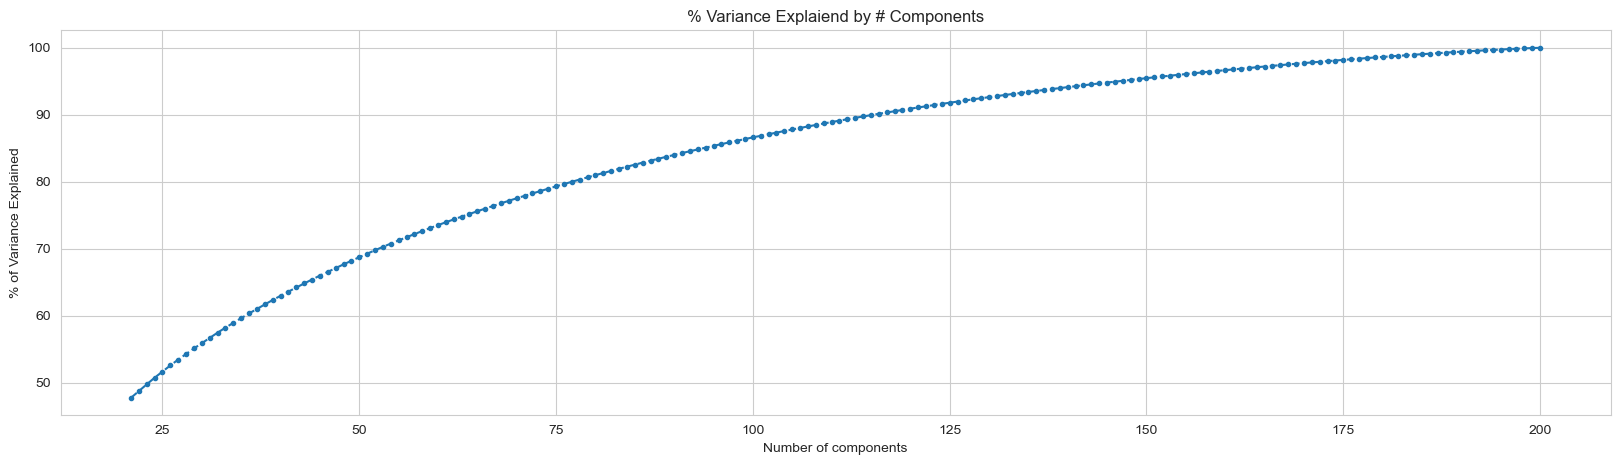

In [28]:
cumulative_variance_ratio = 100*np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize = (20,5))
plt.plot(range(21, 21 + len(cumulative_variance_ratio[20:])), cumulative_variance_ratio[20:], marker = '.', linestyle = '--')
plt.xlabel('Number of components')
plt.ylabel('% of Variance Explained')
plt.title('% Variance Explaiend by # Components')

plt.show()

In [29]:
pca = PCA(n_components = 0.95)
X_pca = pca.fit_transform(X)

## KMeans

In [30]:
k_range = range(10, 61)

inertia = []
silhouette = []
for k in k_range:
    K_model = KMeans(n_clusters = k, max_iter = 200, init = 'k-means++', n_init = 10)
    K_model.fit(X_pca)
    inertia.append(K_model.inertia_)
    
    cluster_labels = K_model.fit_predict(X_pca)
    silhouette.append(silhouette_score(X_pca, cluster_labels))

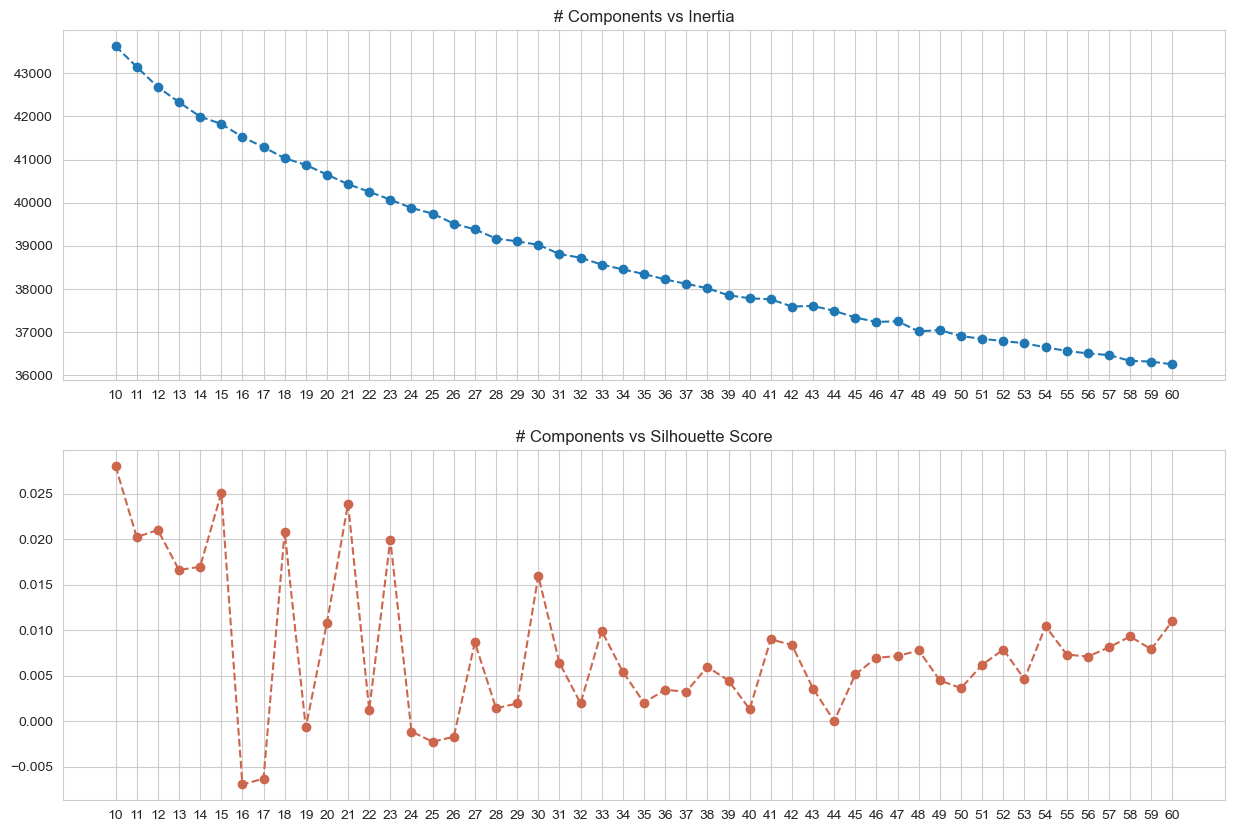

In [31]:
fig, axes = plt.subplots(2, 1, figsize = (15, 10))

axes[0].plot(k_range, inertia, marker = 'o', linestyle = '--')
axes[0].set_xticks(k_range)
axes[0].title.set_text('# Components vs Inertia')

axes[1].plot(k_range, silhouette, marker = 'o', linestyle = '--', color=[0.8, 0.4, 0.3])
axes[1].set_xticks(k_range)
axes[1].title.set_text('# Components vs Silhouette Score')

plt.show()

In [32]:
n_clusters = 21
model_n = KMeans(n_clusters = n_clusters, max_iter = 200, init = 'k-means++', n_init = 10)
model_n.fit(X_pca);

In [33]:
rpg_cluster = top_games_top_tags
rpg_cluster['cluster'] = model_n.labels_
rpg_cluster.reset_index(drop = True, inplace = True)
rpg_cluster[['name', 'tags', 'cluster']]

name  \
0                     Conquest Emperor   
1                           Idle Clans   
2                 EA SPORTS™ PGA TOUR™   
3                  Song Of The Prairie   
4                         EVERSPACE™ 2   
...                                ...   
4889           The Secret of Darkwoods   
4890  Disciples II: Rise of the Elves    
4891    Disciples II: Gallean's Return   
4892            The Ship: Murder Party   
4893         赌神模拟器：亚洲风云God Of Gamblers   

                                                   tags  cluster  
0     [tacticalrpg, nudity, puzzle, singleplayer, me...        6  
1     [freetoplay, singleplayer, pve, combat, crafti...       10  
2     [sports, localcoop, localmultiplayer, coop, mu...        0  
3     [storyrich, exploration, datingsim, drama, far...        4  
4     [actionadventure, scifi, action, singleplayer,...       11  
...                                                 ...      ...  
4889  [singleplayer, medieval, nonlinear, interactiv...        7  
4890  [strategy, classic, darkfantasy, turnbasedstra...       16  
4891  [strategy, classic, isometric, singleplayer, d...       16  
4892  [action, strategy, singleplayer, mystery, funn...        8  
4893  [nudity, singleplayer, mystery, datingsim, 3d,...        6  

[4894 rows x 3 columns]

In [34]:
rpg_cluster[rpg_cluster['cluster'] == 0][['name', 'tags']].head(30)

name  \
2                      EA SPORTS™ PGA TOUR™   
26   Idle Champions of the Forgotten Realms   
54                             Anomaly Zone   
89                             Lords Mobile   
124                    Isekai Eternal Alpha   
211                       LEGO® The Hobbit™   
220                 GunZ 2: The Second Duel   
236             FootLOL: Epic Soccer League   
239                            Original War   
295                         Satellite Reign   
309                          Battle Islands   
364                Gems of War - Puzzle RPG   
379                               The Crew™   
389                           Town of Salem   
443   Navy Field 2 : Conqueror of the Ocean   
479                     RUNNING WITH RIFLES   
515                               Magicka 2   
543                      Tabletop Simulator   
545                        The Red Solstice   
546                         Badland Bandits   
559       Heroes of SoulCraft - Arcade MOBA   
564                           Time Clickers   
653             Crusaders of the Lost Idols   
727                   Lords of the Realm II   
758                          Lost Existence   
808             Dungeon Lords Steam Edition   
818                                   Ceres   
868                       Shakes and Fidget   
958                          Wartune Reborn   
990                              Castlehold   

                                                  tags  
2    [sports, localcoop, localmultiplayer, coop, mu...  
26   [action, strategy, freetoplay, singleplayer, c...  
54   [action, freetoplay, zombies, postapocalyptic,...  
89   [strategy, freetoplay, memes, datingsim, war, ...  
124  [action, scifi, strategy, freetoplay, combat, ...  
211  [action, strategy, puzzle, singleplayer, funny...  
220  [fighting, strategy, action, freetoplay, singl...  
236  [action, singleplayer, memes, funny, topdown, ...  
239  [strategy, scifi, singleplayer, storyrich, war...  
295  [action, strategy, scifi, singleplayer, isomet...  
309  [action, strategy, freetoplay, singleplayer, f...  
364  [strategy, puzzle, freetoplay, singleplayer, p...  
379  [action, singleplayer, arcade, racing, massive...  
389  [action, strategy, mystery, memes, funny, surv...  
443  [action, strategy, freetoplay, singleplayer, m...  
479  [action, singleplayer, isometric, pve, topdown...  
515  [singleplayer, comedy, openworld, localmultipl...  
543  [strategy, funny, 3d, tabletop, firstperson, s...  
545  [scifi, singleplayer, topdown, realtimetactics...  
546  [action, racing, freetoplay, massivelymultipla...  
559  [action, strategy, freetoplay, multiplayer, in...  
564  [action, strategy, freetoplay, singleplayer, s...  
653  [action, strategy, freetoplay, singleplayer, f...  
727  [strategy, classic, medieval, multiplayer, rts...  
758  [action, building, firstperson, difficult, coo...  
808  [action, classic, singleplayer, coop, multipla...  
818  [strategy, freetoplay, singleplayer, 3d, turnb...  
868  [charactercustomization, strategy, classic, fr...  
958  [tacticalrpg, strategy, singleplayer, turnbase...  
990  [strategy, freetoplay, 3d, turnbasedcombat, ca...

In [35]:
rpg_cluster[rpg_cluster['cluster'] == 1][['name', 'tags']].head(30)

name  \
6                  Wayhaven Chronicles: Book Three   
70                                   The HeartBeat   
72                      The Test: Final Revelation   
115                                   Cursed Lands   
122                                   Open Sorcery   
183                       Heroes Rise: The Prodigy   
184                                 Dark Scavenger   
185                  Heroes Rise: The Hero Project   
222                                        Cinders   
233                              Planet Stronghold   
244                                      The Yawhg   
251                                  Fading Hearts   
277                      Always Sometimes Monsters   
285                          Spirited Heart Deluxe   
289                                   Soul Gambler   
290                          Heroes Rise: HeroFall   
315                        Choice of the Deathless   
378            Joe Dever's Lone Wolf HD Remastered   
395                               Choice of Robots   
458  1931: Scheherazade at the Library of Pergamum   
554                           Champion of the Gods   
577                            King of Dragon Pass   
628                                   Black Closet   
655               Dead But Alive! Southern England   
714       MADE : Interactive Movie – 01. Run away!   
735                      I'a I'a Cofflhu Fhtagnyaa   
762                        A Wild Catgirl Appears!   
763                            Open Sorcery: Sea++   
843                                Melancholy Love   
853                         Sorcery! Parts 1 and 2   

                                                  tags  
6    [singleplayer, storyrich, drama, supernatural,...  
70   [scifi, puzzle, singleplayer, timemanagement, ...  
72   [survivalhorror, singleplayer, immersivesim, m...  
115  [nudity, charactercustomization, darkfantasy, ...  
122  [singleplayer, femaleprotagonist, interactivef...  
183  [storyrich, femaleprotagonist, romance, intera...  
184  [scifi, singleplayer, funny, exploration, come...  
185  [storyrich, femaleprotagonist, interactivefict...  
222  [singleplayer, storyrich, datingsim, mature, g...  
233  [strategy, scifi, singleplayer, datingsim, fem...  
244  [storyrich, short, replayvalue, greatsoundtrac...  
251  [singleplayer, fps, jrpg, adventure, conversat...  
277  [singleplayer, pixelgraphics, greatsoundtrack,...  
285  [singleplayer, datingsim, clicker, femaleprota...  
289  [singleplayer, storyrich, short, comicbook, po...  
290  [storyrich, femaleprotagonist, interactivefict...  
315  [femaleprotagonist, interactivefiction, lgbtq+...  
378  [action, singleplayer, storyrich, adventure, i...  
395  [scifi, singleplayer, storyrich, robots, femal...  
458  [singleplayer, storyrich, datingsim, femalepro...  
554  [storyrich, femaleprotagonist, romance, intera...  
577  [1980s, strategy, singleplayer, storyrich, tab...  
628  [strategy, singleplayer, mystery, storyrich, i...  
655  [strategy, scifi, storyrich, zombies, turnbase...  
714  [immersivesim, singleplayer, mystery, realisti...  
735  [scifi, funny, alternatehistory, datingsim, st...  
762  [funny, datingsim, storyrich, comedy, femalepr...  
763  [singleplayer, femaleprotagonist, chooseyourow...  
843  [singleplayer, drama, narration, gore, lgbtq+,...  
853  [storyrich, chooseyourownadventure, interactiv...

In [42]:
rpg_cluster[rpg_cluster['cluster'] == 10][['name', 'tags']].head(30)

name  \
1                          Idle Clans   
27                Guild Wars® Trilogy   
46                           Mabinogi   
82            Uncharted Waters Online   
109                    Arena of Kings   
114                          The Wolf   
118                              MIR4   
123                 Global Adventures   
135             IdleOn - The Idle MMO   
154            Dream Of Mirror Online   
208                       ArcheBlade™   
273                  Fiesta Online NA   
274                           Elsword   
310              Villagers and Heroes   
329                             WAKFU   
367                         Perpetuum   
383                 School of Dragons   
396                  The Repopulation   
442                           8BitMMO   
544                             Trove   
557                           Aberoth   
597                            RPG MO   
604                     Mortal Online   
633                            SMITE®   
642                       Astro Lords   
711  Sphere 3: Rage of the Devastator   
751                           Mytheon   
759                       Dragon Saga   
785                 Kingdoms In Chaos   
804            DreamScapes Dimensions   

                                                  tags  
1    [freetoplay, singleplayer, pve, combat, crafti...  
27        [massivelymultiplayer, mmorpg, fantasy, pvp]  
46   [freetoplay, greatsoundtrack, openworld, jrpg,...  
82   [strategy, freetoplay, massivelymultiplayer, o...  
109  [action, isometric, freetoplay, pve, teambased...  
114  [action, singleplayer, immersivesim, pve, 3d, ...  
118  [action, pve, 3d, war, lorerich, demons, massi...  
123  [action, freetoplay, massivelymultiplayer, mmo...  
135  [freetoplay, pve, crafting, pixelgraphics, old...  
154  [action, freetoplay, massivelymultiplayer, ani...  
208  [fighting, action, freetoplay, massivelymultip...  
273  [action, nudity, freetoplay, massivelymultipla...  
274  [freetoplay, platformer, adventure, sidescroll...  
310  [freetoplay, survival, fps, openworld, adventu...  
329  [freetoplay, turnbasedstrategy, cartoon, openw...  
367  [action, scifi, freetoplay, robots, massivelym...  
383  [freetoplay, singleplayer, survival, firstpers...  
396  [scifi, openworldsurvivalcraft, pve, crafting,...  
442  [freetoplay, pixelgraphics, survival, openworl...  
544  [action, freetoplay, funny, exploration, build...  
557  [action, freetoplay, medieval, pixelgraphics, ...  
597  [isometric, freetoplay, exploration, crafting,...  
604  [freetoplay, survival, fps, firstperson, openw...  
633  [action, strategy, freetoplay, funny, survival...  
642  [action, scifi, strategy, freetoplay, space, p...  
711  [action, charactercustomization, freetoplay, 3...  
751  [action, classic, pve, mythology, multiplayer,...  
759  [action, freetoplay, racing, dragons, massivel...  
785  [actionadventure, action, openworldsurvivalcra...  
804  [freetoplay, combat, 3d, building, medieval, m...

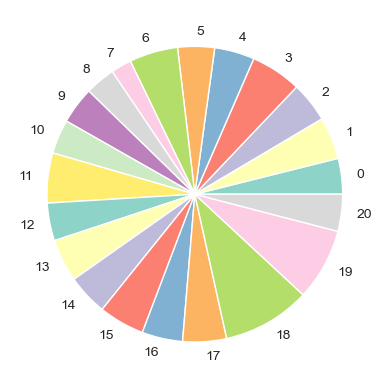

In [43]:
colors = sns.color_palette('Set3')[0:n_clusters]
plt.pie(rpg_cluster.groupby('cluster').size(),
        labels = range(0, n_clusters), colors = colors);

In [63]:
rpg_cluster.to_csv('rpg_cluster_21.csv', index = False)

## Looking into each cluster

In [44]:
from math import dist, ceil

In [45]:
def find_nearest_points(center, points):
    nearest = points.pop()
    d_nearest = dist(center, nearest)
    for point in points:
        if dist(center, point) < d_nearest:
            nearest = point
            d_nearest = dist(center, nearest)

In [46]:
nearest_i = []

for n in range(n_clusters):
    all_i = np.where(model_n.labels_ == n)[0]
    points = X_pca[all_i]
    n_points = points.shape[0]
    
    center = model_n.cluster_centers_[n]
    
    distances = [dist(points[k], center) for k in range(n_points)]
    min_i = int(np.argmin(distances))
    min_i = all_i[min_i]
    nearest_i.append(int(min_i))

In [47]:
rpg_cluster.loc[nearest_i][['name', 'tags', 'cluster']]

name  \
559                   Heroes of SoulCraft - Arcade MOBA   
2809                                      Just One Line   
2511                                      FOX n FORESTS   
3745                                        bit Dungeon   
555                      Holy Potatoes! A Weapon Shop?!   
2680                            Ys: Memories of Celceta   
2410                                 Chevalier Historie   
4287                Realms of Arkania: Blade of Destiny   
4876                            The Ship: Single Player   
4881                                  Langrisser I & II   
154                              Dream Of Mirror Online   
4665           Gothic 3: Forsaken Gods Enhanced Edition   
3044                              Tech Executive Tycoon   
970                                             Goliath   
168                              FATE: The Traitor Soul   
3615                                       Fate Hunters   
194                             Ascension to the Throne   
300   8-Bit Adventures 1: The Forgotten Journey Rema...   
2768                                  Duck Life: Battle   
813                                          BuriedTown   
3659                       The Forest of Drizzling Rain   

                                                   tags  cluster  
559   [action, strategy, freetoplay, multiplayer, in...        0  
2809  [storyrich, adventure, textbased, indie, casua...        1  
2511  [action, platformer, singleplayer, pixelgraphi...        2  
3745  [action, roguelike, roguelite, actionroguelike...        3  
555   [singleplayer, funny, crafting, management, si...        4  
2680  [action, singleplayer, greatsoundtrack, anime,...        5  
2410  [nudity, singleplayer, memes, mature, femalepr...        6  
4287  [singleplayer, firstperson, partybasedrpg, tur...        7  
4876  [action, singleplayer, shooter, fps, firstpers...        8  
4881  [tacticalrpg, strategy, classic, singleplayer,...        9  
154   [action, freetoplay, massivelymultiplayer, ani...       10  
4665  [action, singleplayer, gothic, atmospheric, op...       11  
3044          [strategy, management, indie, simulation]       12  
970   [action, openworldsurvivalcraft, singleplayer,...       13  
168   [action, singleplayer, loot, dungeoncrawler, f...       14  
3615  [roguelike, strategy, roguelite, singleplayer,...       15  
194   [strategy, singleplayer, turnbasedstrategy, tu...       16  
300   [singleplayer, turnbasedcombat, pixelgraphics,...       17  
2768                 [sports, adventure, indie, casual]       18  
813                [action, strategy, adventure, indie]       19  
3659  [actionadventure, singleplayer, storyrich, pix...       20

In [49]:
silhouette_coeff = silhouette_samples(X, cluster_labels)
rpg_cluster['silhouette_coeff'] = silhouette_coeff

In [50]:
rpg_cluster.loc[rpg_cluster.reset_index().groupby('cluster')['silhouette_coeff'].idxmax()][['name', 'tags', 'cluster']]

name  \
3258                           Refight:The Last Warship   
1394                           VERSUS: The Elite Trials   
4541                                           WarriOrb   
3098                           Cult Of Babel : Prologue   
3975                                         Littlewood   
1491  Atelier Sophie: The Alchemist of the Mysteriou...   
2124                   Obscurite Magie: The City of Sin   
4236               Wizardry 6: Bane of the Cosmic Forge   
1486                                         Precursors   
3153                               La Pucelle: Ragnarok   
4511                                       Bless Global   
4717  The Elder Scrolls III: Morrowind® Game of the ...   
153                                     Dead In Bermuda   
1900                              ARK: Survival Evolved   
4723                            Wolcen: Lords of Mayhem   
3464                                         Blood Card   
2037                                         Warbanners   
229                                 The Book of Legends   
913                                    Guns of Infinity   
594                                    All Guns On Deck   
3899                                   Lenin - The Lion   

                                                   tags  cluster  
3258  [action, strategy, freetoplay, massivelymultip...        0  
1394  [storyrich, chooseyourownadventure, interactiv...        1  
4541  [action, platformer, singleplayer, storyrich, ...        2  
3098  [roguelite, roguelike, action, singleplayer, a...        3  
3975  [charactercustomization, exploration, crafting...        4  
1491  [singleplayer, storyrich, crafting, turnbasedc...        5  
2124  [nudity, singleplayer, memes, mature, femalepr...        6  
4236  [classic, singleplayer, turnbasedcombat, oldsc...        7  
1486             [action, scifi, space, fps, openworld]        8  
3153  [singleplayer, turnbasedstrategy, turnbasedcom...        9  
4511  [freetoplay, exploration, 3d, medieval, massiv...       10  
4717  [action, charactercustomization, classic, sing...       11  
153   [strategy, singleplayer, crafting, survival, m...       12  
1900  [action, scifi, singleplayer, openworldsurviva...       13  
4723  [singleplayer, controller, adventure, actionrp...       14  
3464  [roguelite, strategy, roguelike, singleplayer,...       15  
2037  [singleplayer, turnbasedstrategy, turnbasedcom...       16  
229   [singleplayer, pixelgraphics, replayvalue, gre...       17  
913   [adventure, interactivefiction, textbased, ind...       18  
594   [action, strategy, simulation, indie, casual, ...       19  
3899  [puzzle, singleplayer, storyrich, pixelgraphic...       20

In [51]:
rep_games = rpg_cluster[rpg_cluster['silhouette_coeff'] > 0].sort_values('num_reviews').drop_duplicates(['cluster'], keep='last')
rep_games = rep_games[['name', 'tags', 'cluster']].sort_values('cluster')
rep_games

name  \
4406                                   PlanetSide 2   
4789                                       The Test   
981    Ori and the Blind Forest: Definitive Edition   
3734                                          Hades   
883                                  Stardew Valley   
246                        FINAL FANTASY XIV Online   
4146                                Summer Memories   
2821  Pathfinder: Kingmaker - Enhanced Plus Edition   
4359                                       Warframe   
1583                                Battle Brothers   
1856                                      New World   
510                       The Witcher® 3: Wild Hunt   
1340                                 Going Medieval   
1900                          ARK: Survival Evolved   
871                                       Grim Dawn   
3115                                 Slay the Spire   
832                                         XCOM® 2   
551                                   Eternal Senia   
4160           Open World Game: the Open World Game   
4083                                  The Wind Road   
621                                       Undertale   

                                                   tags  cluster  
4406  [freetoplay, space, fps, firstperson, openworl...        0  
4789  [survivalhorror, singleplayer, immersivesim, m...        1  
981   [puzzle, platformer, singleplayer, controller,...        2  
3734  [singleplayer, actionroguelike, greatsoundtrac...        3  
883   [singleplayer, datingsim, crafting, building, ...        4  
246   [singleplayer, greatsoundtrack, openworld, jrp...        5  
4146  [singleplayer, pixelgraphics, fps, jrpg, adven...        6  
2821  [nudity, strategy, charactercustomization, sin...        7  
4359  [action, scifi, freetoplay, space, singleplaye...        8  
1583  [turnbasedstrategy, turnbasedcombat, replayval...        9  
1856  [singleplayer, violent, openworld, adventure, ...       10  
510   [singleplayer, greatsoundtrack, dark, openworl...       11  
1340  [strategy, singleplayer, 3d, building, medieva...       12  
1900  [action, scifi, singleplayer, openworldsurviva...       13  
871   [action, singleplayer, isometric, darkfantasy,...       14  
3115  [roguelite, strategy, roguelike, singleplayer,...       15  
832   [singleplayer, turnbasedstrategy, greatsoundtr...       16  
551   [puzzle, freetoplay, singleplayer, pixelgraphi...       17  
4160  [freetoplay, memes, simulation, 2d, openworld,...       18  
4083  [action, puzzle, singleplayer, openworld, swor...       19  
621   [singleplayer, pixelgraphics, bullethell, grea...       20

In [52]:
reps = rep_games['name'].tolist()

In [53]:
labels = model_n.labels_
features = vectorizer.get_feature_names_out()

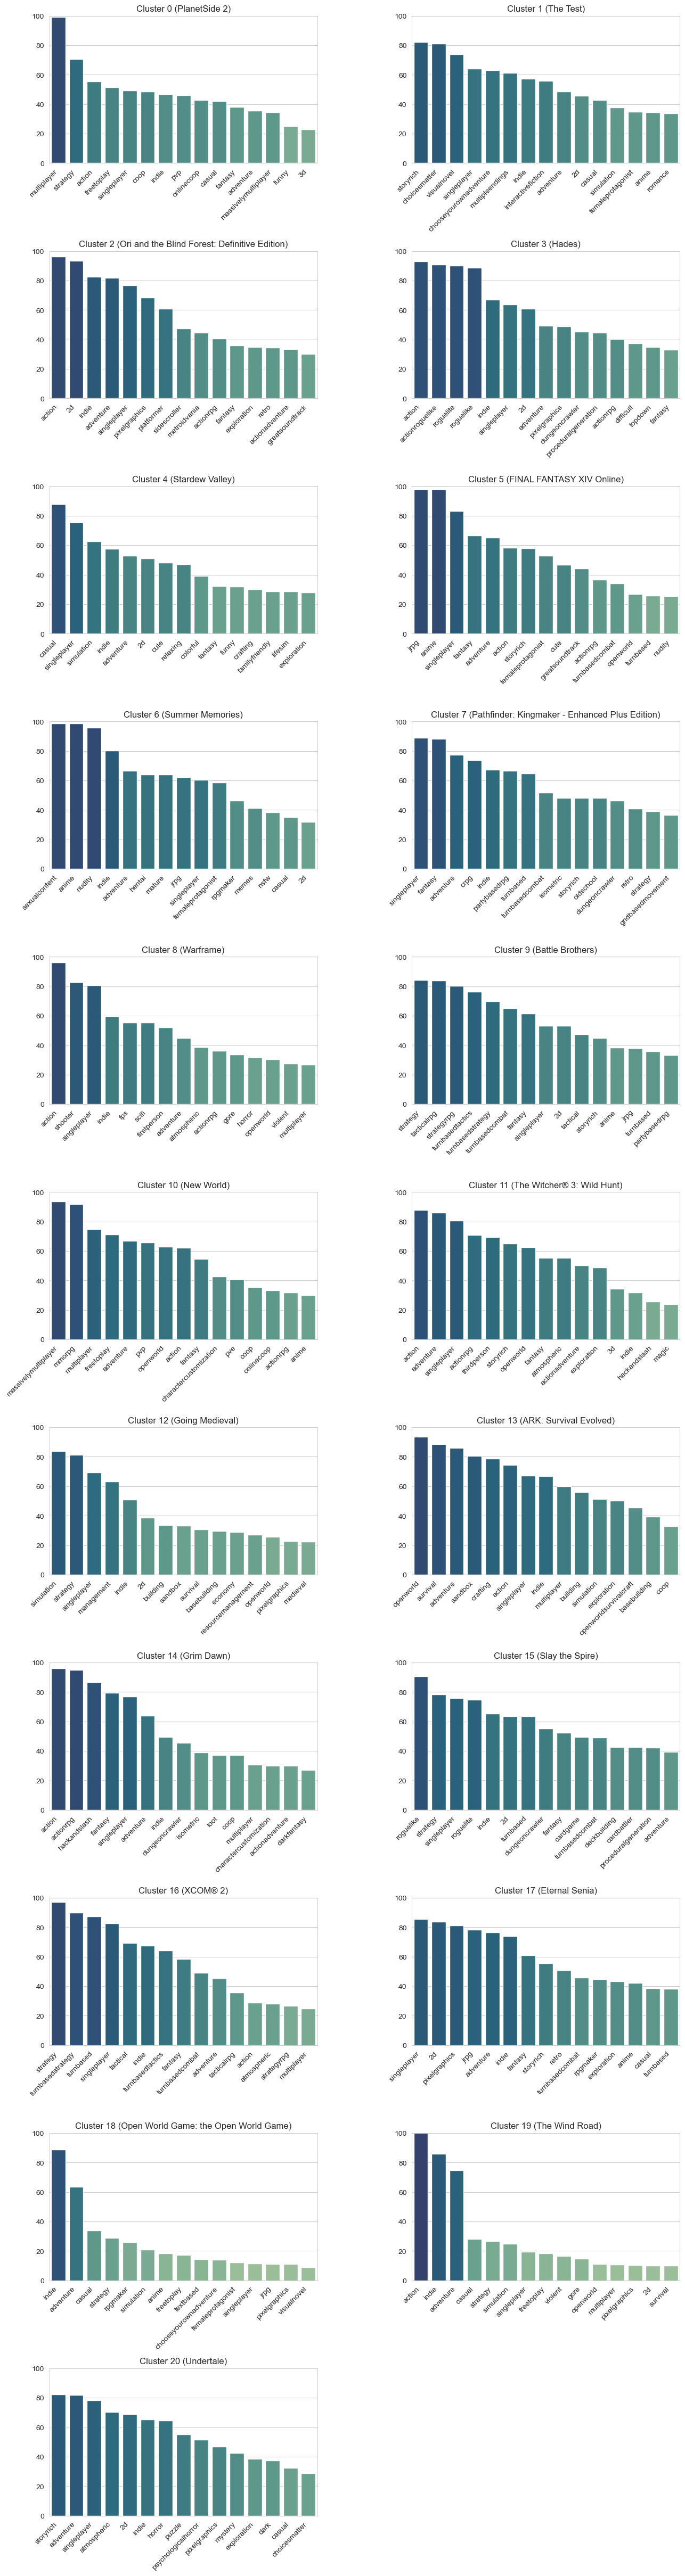

In [54]:
fig, axes = plt.subplots(ceil(n_clusters/2), 2, figsize = (15, 50))
fig.tight_layout(pad = 10.0)

for n in range(n_clusters):
    i_n = X[np.where(labels == n)]
    N = len(X[i_n])
    
    tag_percentages = sum(i_n, 1) * 100 / N
    
    i_common = np.argsort(-tag_percentages)[0:15]
    common_tags_per = tag_percentages[i_common]
    common_tags = features[i_common]
    
    plot_df = pd.DataFrame({'x': common_tags, 'y': common_tags_per})
    plot_df['hue'] = plot_df.apply(lambda row: (row['y'] > 66 and 2) or (row['y'] > 33 and 1) or 0, axis = 1)
    
    palette = sns.color_palette("crest", 15)
    color_i = np.floor(common_tags_per*15/100).astype(np.int32) - 1
    sns.barplot(ax = axes[n//2, n%2], x = common_tags, y = common_tags_per, 
                palette = np.array(palette).take(color_i, axis = 0))
    
    axes[n//2, n%2].set_xticklabels(common_tags[0:15], rotation = 45, ha = 'right')
    axes[n//2, n%2].set_ylim(0, 100)
    axes[n//2, n%2].title.set_text(f'Cluster {n} ({reps[n]})')

if n_clusters%2 == 1:
    axes[-1, -1].axis('off')

    
plt.show()

In [55]:
rpg_cluster[rpg_cluster['cluster'] == 18].sort_values(by = 'silhouette_coeff', ascending = False).head(10)

name  \
1558               The Lost Heir 3: Demon War   
917                        Sabres of Infinity   
913                          Guns of Infinity   
542                                  Tin Star   
2388                     Fallen Hero: Rebirth   
620                        A Wise Use of Time   
1086  Affairs of the Court: Choice of Romance   
1198                                Fatehaven   
1201                         Samurai of Hyuga   
1631                     Welcome to Moreytown   

                                                   tags  num_reviews  \
1558  [adventure, interactivefiction, textbased, ind...         32.0   
917   [adventure, interactivefiction, indie, textbas...        131.0   
913   [adventure, interactivefiction, textbased, ind...        101.0   
542   [interactivefiction, textbased, indie, choices...        282.0   
2388  [adventure, interactivefiction, lgbtq+, indie,...        317.0   
620   [interactivefiction, lgbtq+, indie, textbased,...        117.0   
1086  [romance, adventure, interactivefiction, textb...         63.0   
1198  [adventure, interactivefiction, indie, textbas...         76.0   
1201  [adventure, interactivefiction, indie, textbas...         48.0   
1631  [adventure, interactivefiction, textbased, ind...         42.0   

      num_positive_reviews                                                url  \
1558                  19.0  https://store.steampowered.com/app/596540/The_...   
917                  123.0  https://store.steampowered.com/app/446310/Sabr...   
913                   97.0  https://store.steampowered.com/app/446330/Guns...   
542                  269.0  https://store.steampowered.com/app/375130/Tin_...   
2388                 308.0  https://store.steampowered.com/app/800620/Fall...   
620                   94.0  https://store.steampowered.com/app/397780/A_Wi...   
1086                  49.0  https://store.steampowered.com/app/492370/Affa...   
1198                  58.0  https://store.steampowered.com/app/524520/Fate...   
1201                  40.0  https://store.steampowered.com/app/524540/Samu...   
1631                  34.0  https://store.steampowered.com/app/625990/Welc...   

      release_month  release_day  release_year  cluster  silhouette_coeff  
1558              3           17          2017       18          0.289151  
917               6           21          2013       18          0.289151  
913               3           29          2016       18          0.289151  
542               2           21          2014       18          0.279108  
2388              3           15          2018       18          0.273604  
620               9            4          2015       18          0.271285  
1086              8           16          2013       18          0.260170  
1198              8            8          2014       18          0.249116  
1201              7           17          2015       18          0.249116  
1631              5            5          2017       18          0.249116

In [56]:
rpg_cluster[rpg_cluster['cluster'] == 18].sort_values(by = 'silhouette_coeff', ascending = True).head(10)

name  \
4809                  Culpa Innata   
1057  Vanilla Bagel: The Roguelike   
1739              We Slay Monsters   
41       Sherlock Holmes - Nemesis   
4518               Before the Echo   
223                      NEStalgia   
3807                   Pesterquest   
1096          Conquer The Universe   
2521                  Devil's Deck   
3122                   Idle Wizard   

                                                   tags  num_reviews  \
4809  [scifi, storyrich, cyberpunk, mystery, femalep...         88.0   
1057   [roguelike, pixelgraphics, 2d, indie, adventure]         33.0   
1739  [roguelike, strategy, traditionalroguelike, du...         72.0   
41    [puzzle, mystery, investigation, firstperson, ...        407.0   
4518  [singleplayer, funny, greatsoundtrack, comedy,...       1009.0   
223   [massivelymultiplayer, pixelgraphics, multipla...        239.0   
3807  [scifi, storyrich, funny, comedy, greatsoundtr...       1050.0   
1096         [strategy, freetoplay, clicker, idler, 2d]         29.0   
2521  [roguelite, strategy, cardgame, indie, adventu...        207.0   
3122        [freetoplay, clicker, idler, magic, casual]       1172.0   

      num_positive_reviews                                                url  \
4809                  65.0  https://store.steampowered.com/app/12310/Culpa...   
1057                  22.0  https://store.steampowered.com/app/491510/Vani...   
1739                  68.0  https://store.steampowered.com/app/332540/We_S...   
41                   297.0  https://store.steampowered.com/app/11040/Sherl...   
4518                 900.0  https://store.steampowered.com/app/200910/Befo...   
223                  153.0  https://store.steampowered.com/app/249550/NESt...   
3807                 975.0  https://store.steampowered.com/app/1144030/Pes...   
1096                  16.0  https://store.steampowered.com/app/1537030/Con...   
2521                 139.0  https://store.steampowered.com/app/1093320/Dev...   
3122                1017.0  https://store.steampowered.com/app/992070/Idle...   

      release_month  release_day  release_year  cluster  silhouette_coeff  
4809             10           23          2007       18         -0.197245  
1057              6           15          2016       18         -0.188043  
1739              6           21          2017       18         -0.185246  
41                4           14          2008       18         -0.179118  
4518             10           20          2011       18         -0.172403  
223               4           15          2014       18         -0.170692  
3807              9            4          2019       18         -0.166129  
1096              3           29          2021       18         -0.158242  
2521              3           24          2022       18         -0.157751  
3122              1           25          2019       18         -0.144594

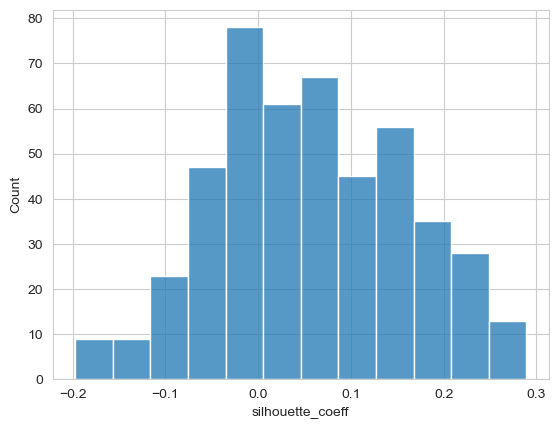

In [57]:
sns.histplot(data = rpg_cluster[rpg_cluster['cluster'] == 18], x = "silhouette_coeff");

## Trend Analysis

In [64]:
import datetime

In [65]:
rpg_cluster['release_date'] = rpg_cluster['release_year']*10000 + rpg_cluster['release_month']*100 + rpg_cluster['release_day']
rpg_cluster['release_date'] = pd.to_datetime(rpg_cluster['release_date'], format='%Y%m%d')
rpg_cluster['release_q'] = rpg_cluster['release_date'].dt.to_period('Q')

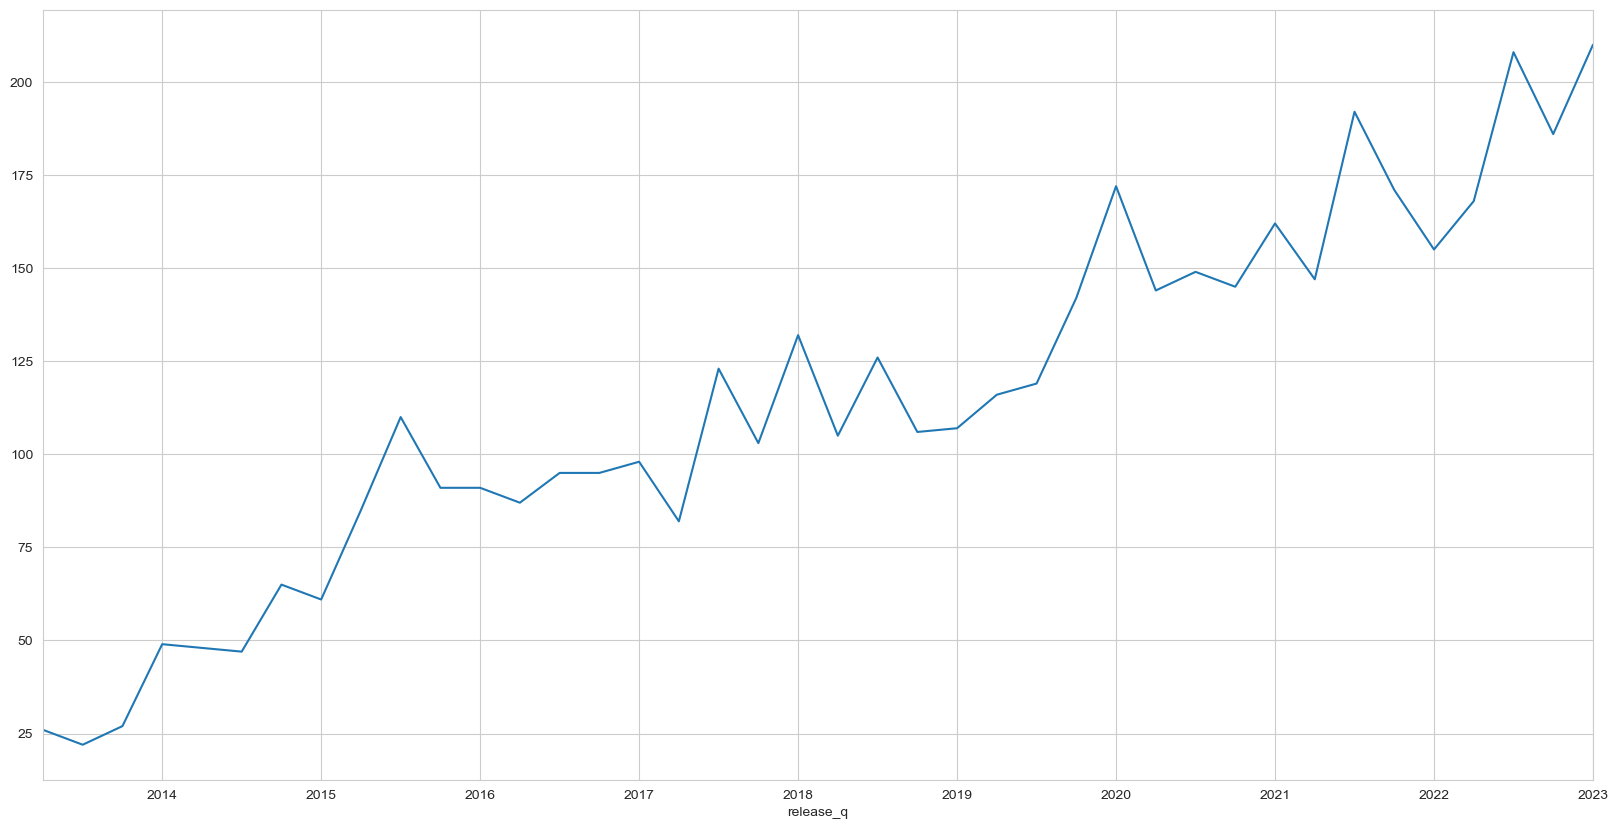

In [81]:
plot_df = rpg_cluster[('2013-04-01' <= rpg_cluster['release_date']) & (rpg_cluster['release_date'] < '2023-04-01')].groupby(['release_q','cluster']).agg(count=('cluster', 'count'))
plot_df = plot_df.unstack(fill_value=0).stack()
plot_df.reset_index(inplace = True)
plot_df[['release_q', 'count']].groupby('release_q').sum().plot(legend = False, figsize = (20, 10));

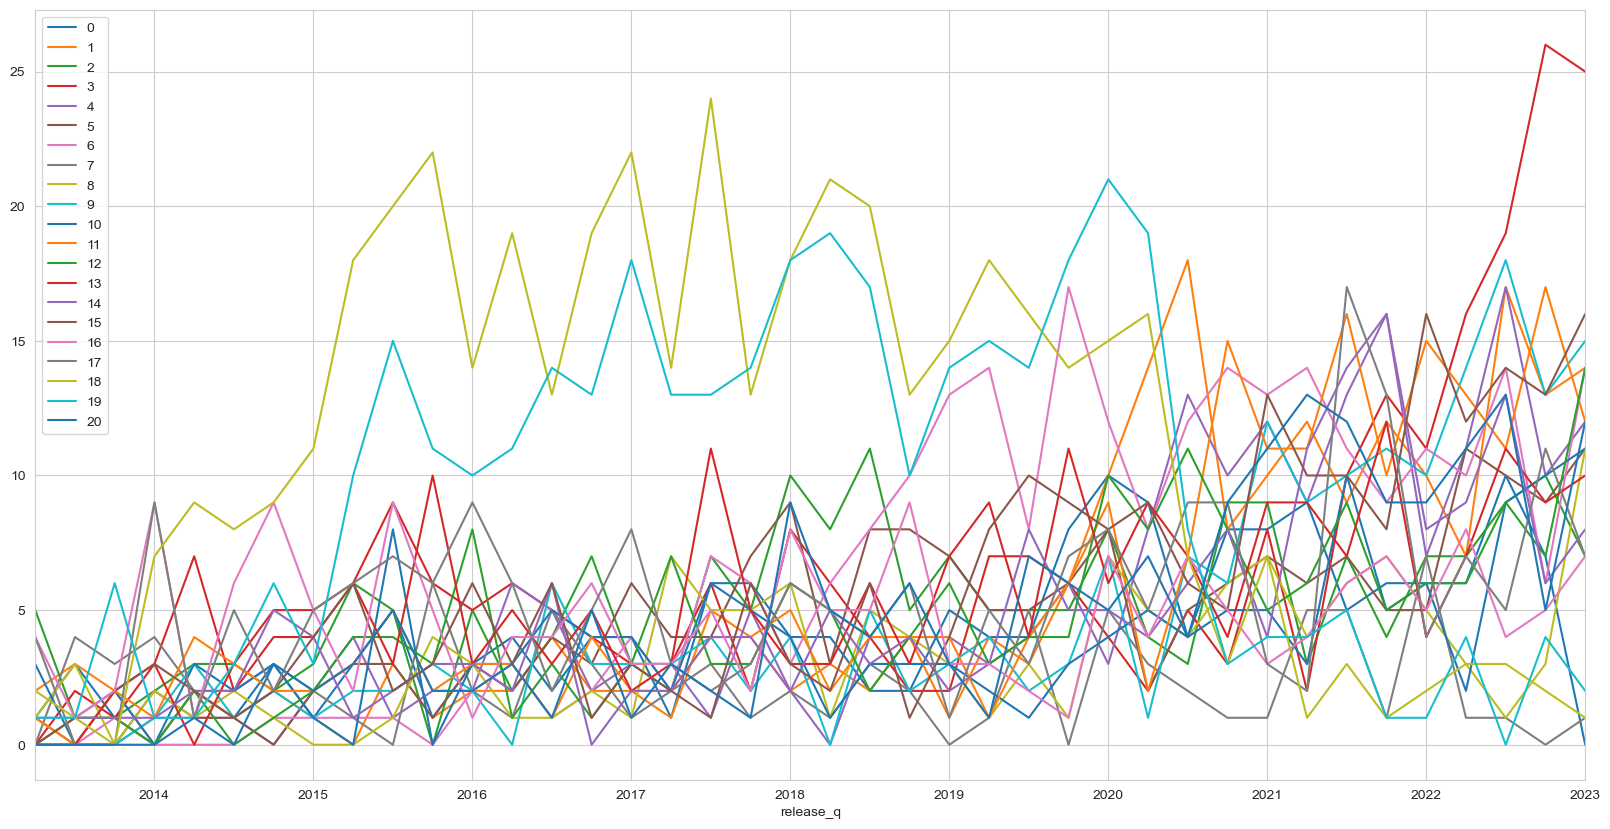

In [82]:
plot_df.set_index('release_q').groupby('cluster')['count'].plot(legend=True, figsize = (20, 10));

In [68]:
import matplotlib.dates as mdates
from pandas.tseries.offsets import DateOffset

In [83]:
# Convert Quarters to actual dates (end date of each quarter) for plotting.
plot_df['release_q'] = plot_df['release_q'].dt.to_timestamp() 

In [84]:
quarters = (pd.date_range(pd.to_datetime('2013-04-01'), pd.to_datetime('2023-03-31') + pd.offsets.QuarterBegin(1), freq='Q').to_period('Q').
            strftime('%Y Q%q').tolist())

for i in range(len(quarters)):
    if 'Q1' in quarters[i]:
        quarters[i] = quarters[i].split(' ')[0]
    else:
        quarters[i] = ''

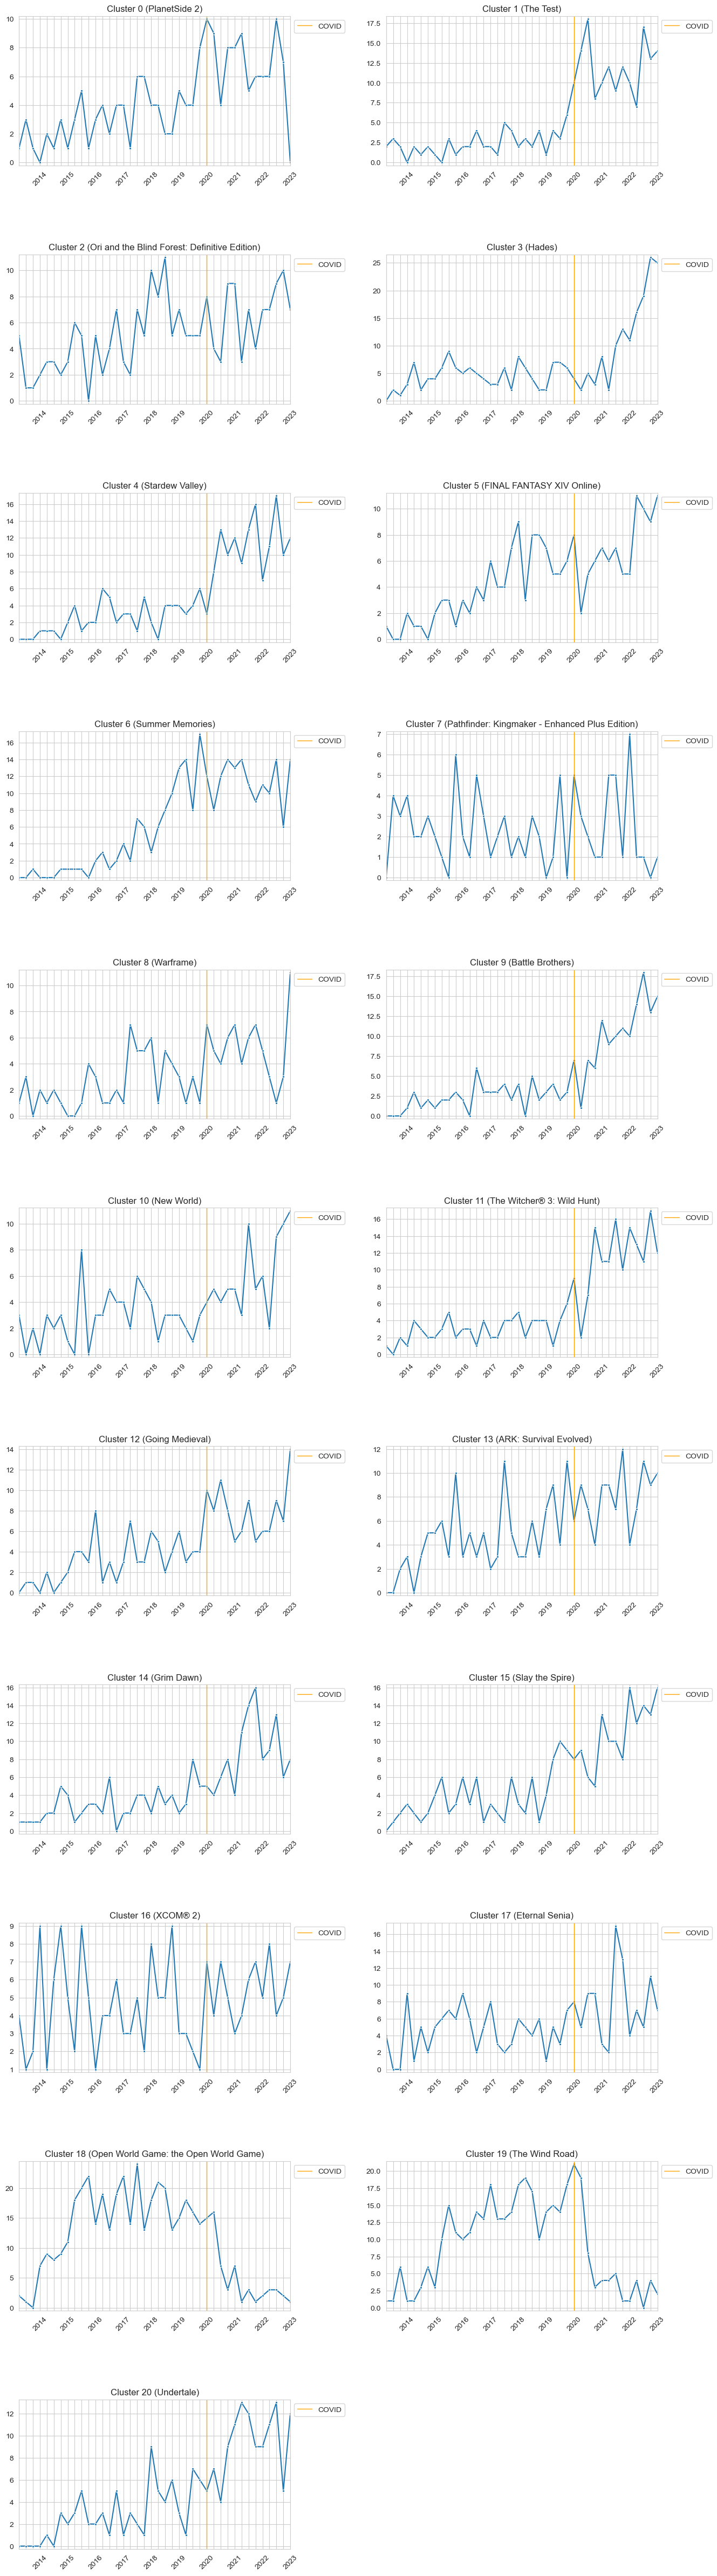

In [87]:
fig, axes = plt.subplots(ceil(n_clusters/2), 2, figsize = (15, 50))
fig.tight_layout(pad = 10.0)

for n in range(n_clusters):
    sns.lineplot(data = plot_df[plot_df['cluster'] == n], x = 'release_q', y = 'count', ax = axes[n//2, n%2], marker = '.');
    
    axes[n//2, n%2].axvline(x = pd.Timestamp(2020,1,1), lw = 1, ls = '-', color = 'orange', label = 'COVID')
    
    axes[n//2, n%2].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    axes[n//2, n%2].set_xticklabels(quarters, rotation = 45, ha = 'center')
    axes[n//2, n%2].xaxis.set_label_text('')
    axes[n//2, n%2].yaxis.set_label_text('')
    
    axes[n//2, n%2].margins(x = 0, y = 0.02)
       
    axes[n//2, n%2].title.set_text(f'Cluster {n} ({reps[n]})')
    
    axes[n//2, n%2].legend(bbox_to_anchor=(1.0, 1), loc='upper left')


if n_clusters%2 == 1:
    axes[-1, -1].axis('off')
    
plt.show()

In [72]:
plot_df = rpg_cluster
plot_df = plot_df.groupby(['release_year','cluster']).agg(count=('cluster', 'count')).unstack(fill_value=0).stack()
plot_df.reset_index(inplace = True)
plot_df = plot_df[(2003 <= plot_df['release_year']) & (plot_df['release_year'] < 2023)]

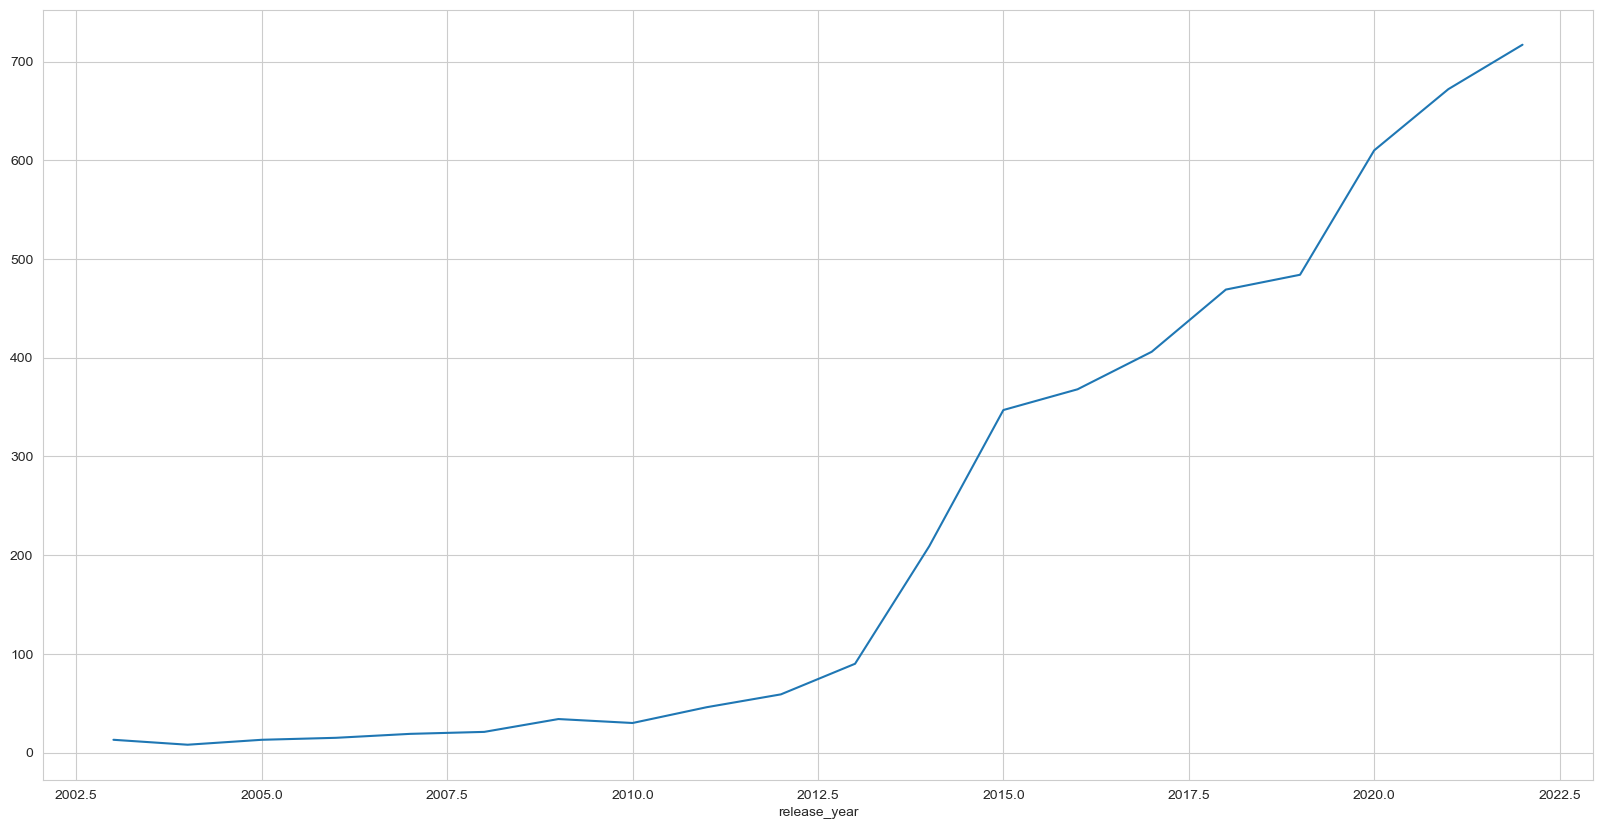

In [76]:
d = plot_df[['release_year', 'count']].groupby('release_year').sum().plot(figsize = (20, 10), legend = False);

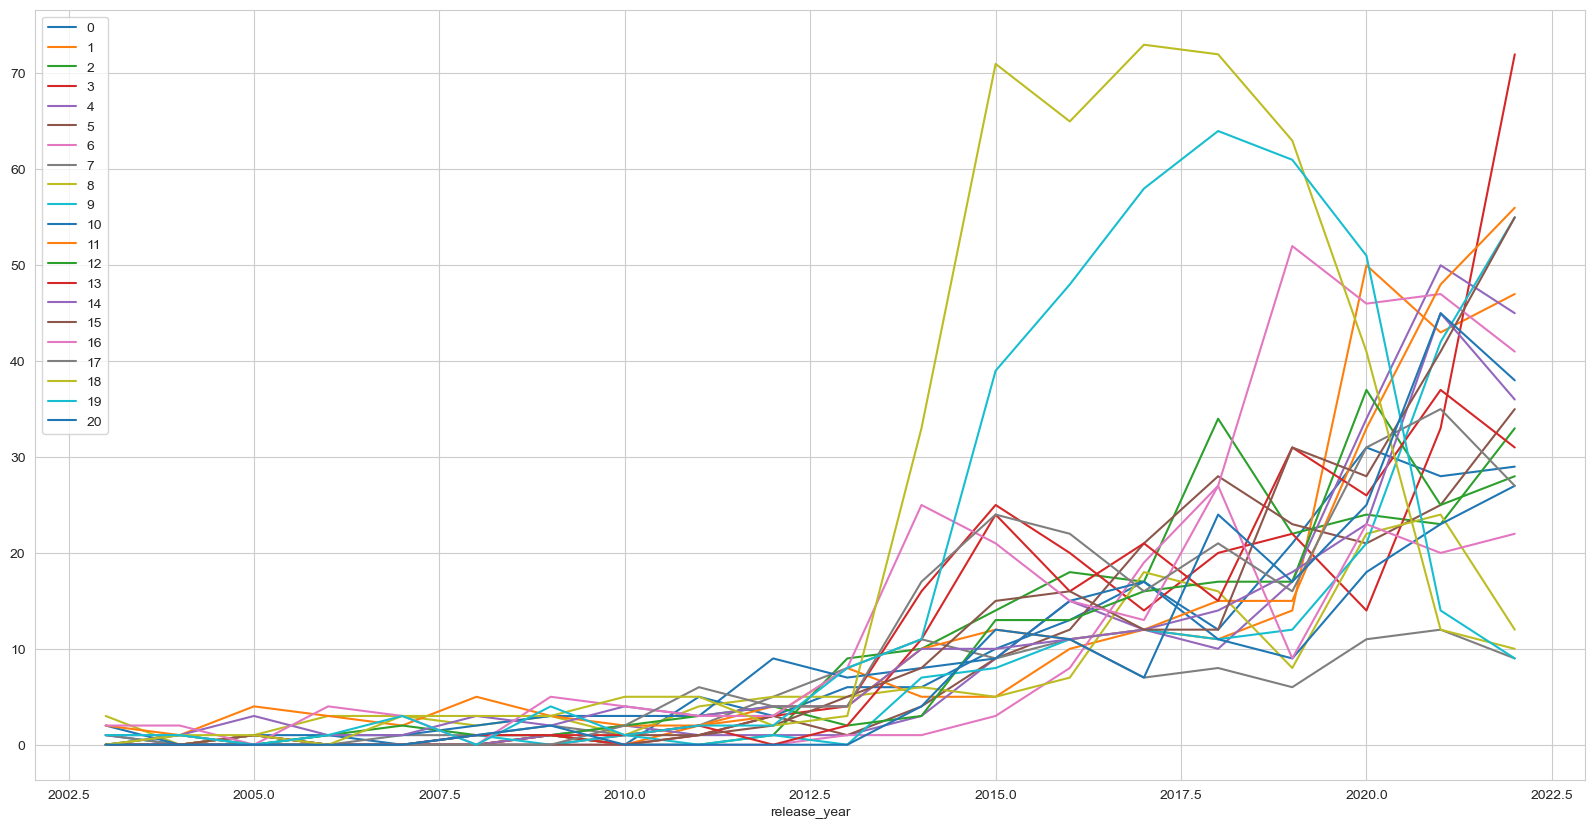

In [75]:
plot_df.set_index('release_year').groupby('cluster')['count'].plot(legend=True, figsize = (20, 10));

In [77]:
from matplotlib.ticker import MaxNLocator

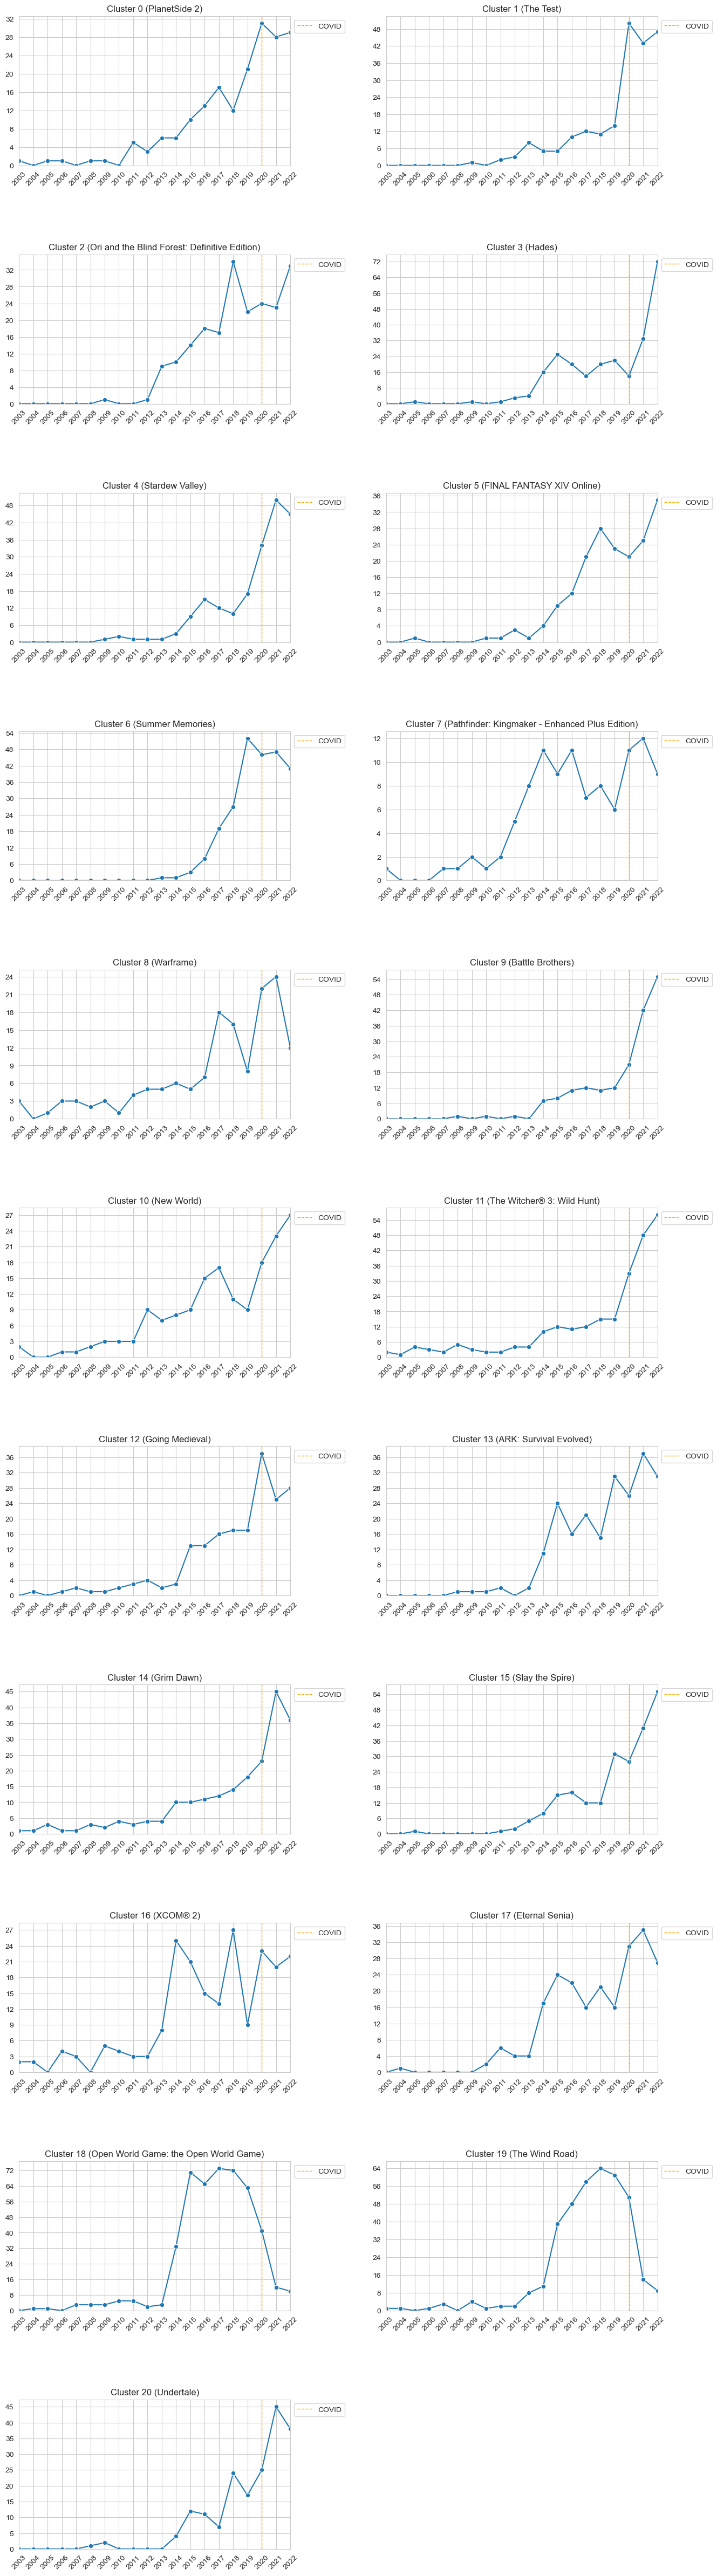

In [80]:
fig, axes = plt.subplots(ceil(n_clusters/2), 2, figsize = (15, 50))
fig.tight_layout(pad = 10.0)

years = [y for y in range(2003, 2023)]

for n in range(n_clusters):
    sns.lineplot(data = plot_df[plot_df['cluster'] == n], x = 'release_year', y = 'count', ax = axes[n//2, n%2], marker = 'o');
    
    axes[n//2, n%2].axvline(x = 2020, lw = 1, ls = '--', color = 'orange', label = 'COVID')

    axes[n//2, n%2].set_xticks(years)
    axes[n//2, n%2].set_xticklabels(years, rotation = 45, ha = 'center')
    
    axes[n//2, n%2].yaxis.set_major_locator(MaxNLocator(integer=True))
    axes[n//2, n%2].set_ylim(ymin=0)
    
    axes[n//2, n%2].title.set_text(f'Cluster {n} ({reps[n]})')
    
    axes[n//2, n%2].xaxis.set_label_text('')
    axes[n//2, n%2].yaxis.set_label_text('')
    
    axes[n//2, n%2].margins(x = 0, y = 0.2)
    
    axes[n//2, n%2].legend(bbox_to_anchor=(1.0, 1), loc='upper left')

if n_clusters%2 == 1:
    axes[-1, -1].axis('off')
    
plt.show()